In [ ]:
# Import necessary libraries
import pandas as pd

# Load the CSV file (replace 'Your_File_Name.csv' with your actual file name)
file_path = "Patient_table.csv"  # Replace with the correct file path
data = pd.read_csv(file_path)

# Display the first few rows to inspect the data
print("First few rows of the data:")
print(data.head())

# Check the shape of the dataset
print("\nShape of the dataset:")
print(data.shape)

# Check for duplicate `patient_id` values
duplicates = data[data.duplicated(subset='patient_id', keep=False)]
print("\nDuplicate patient_ids:")
print(duplicates)

# Check for missing values in the dataset
missing_values = data.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

# Validate data types of each column
data_types = data.dtypes
print("\nData types of each column:")
print(data_types)

# Check for rows with invalid or unusual values
print("\nRows with missing or zero values in key columns (patient_id, etc.):")
print(data[(data['patient_id'].isnull()) | (data['patient_id'] == 0)])


First few rows of the data:
   s.no patient_barcode visit_id tissue_source_site  \
0     0    TCGA-2H-A9GF       A1                 2H   
1     1    TCGA-2H-A9GG       A2                 2H   
2     2    TCGA-2H-A9GH       A3                 2H   
3     3    TCGA-2H-A9GI       A4                 2H   
4     4    TCGA-2H-A9GJ       A5                 2H   

                       bcr_patient_uuid patient_id country_of_birth gender  \
0  0500F1A6-A528-43F3-B035-12D3B7C99C0F   TCGA0001                0   MALE   
1  70084008-697D-442D-8F74-C12F8F598570   TCGA0002                0   MALE   
2  606DC5B8-7625-42A6-A936-504EF25623A4   TCGA0003                0   MALE   
3  CEAF98F8-517E-457A-BF29-ACFE22893D49   TCGA0004                0   MALE   
4  EE47CD59-C8D8-4B1E-96DB-91C679E4106F   TCGA0005                0   MALE   

   height  weight  days_to_birth race_list ethnicity  days_to_last_followup  
0     183      95         -24487         0         0                      0  
1     178      7

In [ ]:
# Check the maximum length of string columns
string_columns = ['patient_barcode', 'visit_id', 'tissue_source_site', 'bcr_patient_uuid',
                  'patient_id', 'country_of_birth', 'gender', 'race_list', 'ethnicity']
for col in string_columns:
    print(f"Max length of {col}: {data[col].str.len().max()}")


Max length of patient_barcode: 36
Max length of visit_id: 4
Max length of tissue_source_site: 2
Max length of bcr_patient_uuid: 36
Max length of patient_id: 8
Max length of country_of_birth: 14
Max length of gender: 6
Max length of race_list: 25
Max length of ethnicity: 22


In [ ]:
import pandas as pd

# Load your CSV file
df = pd.read_csv('Patient_table.csv')

# Check for duplicate PRIMARY KEY values
duplicate_keys = df[df.duplicated(subset=['patient_id'], keep=False)]

if duplicate_keys.empty:
    print("No duplicate patient_id values found in the dataset.")
else:
    print("Duplicate patient_id values:")
    print(duplicate_keys)


No duplicate patient_id values found in the dataset.


In [ ]:
import pandas as pd
import sqlite3

# File paths (update with actual paths if needed)
files = {
    "Patient_table": "Patient_table.csv",
    "Visit_table": "Visit_table.csv",
    "Country_table": "country_table.csv",
    "Treatment_table": "treatment_table.csv",
    "Diagnosis_table": "diagnosis_table.csv",
    "Outcome_table": "outcome_table.csv"
}

# Connect to SQLite database (in-memory)
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Load CSVs into DataFrames and create tables
for table_name, file_path in files.items():
    df = pd.read_csv(file_path)
    df.to_sql(table_name, conn, if_exists="replace", index=False)

# Queries
queries = [
    """
    SELECT
        '1. The most common tumor location among patients is' AS Question,
        primary_pathology_esophageal_tumor_cental_location || ' with ' || COUNT(*) || ' occurrences.' AS Answer
    FROM Diagnosis_table
    GROUP BY primary_pathology_esophageal_tumor_cental_location
    ORDER BY COUNT(*) DESC
    LIMIT 1
    """,
    """
    SELECT
        '2. The average Karnofsky performance score for patients with residual tumors is' AS Question,
        ROUND(AVG(o.primary_pathology_karnofsky_performance_score), 2) || '.' AS Answer
    FROM Treatment_table t
    JOIN Outcome_table o ON t.visit_id = o.visit_id
    WHERE t.primary_pathology_residual_tumor = 'R1'
    """,
    """
    SELECT
        '3. The number of patients with columnar metaplasia present is' AS Question,
        COUNT(*) || ' patients.' AS Answer
    FROM Diagnosis_table
    WHERE primary_pathology_columnar_metaplasia_present = 1
    """,
    """
    SELECT
        '4. The percentage of patients who underwent radiation therapy is' AS Question,
        ROUND((COUNT(*) * 100.0) / (SELECT COUNT(*) FROM Treatment_table), 2) || '%' AS Answer
    FROM Treatment_table
    WHERE primary_pathology_radiation_therapy = 'YES'
    """,
    """
    SELECT
        '5. The country with the highest number of esophageal cancer cases is' AS Question,
        c.country || ' with ' || COUNT(*) || ' cases.' AS Answer
    FROM Country_table c
    JOIN Patient_table p ON c.patient_id = p.patient_id
    GROUP BY c.country
    ORDER BY COUNT(*) DESC
    LIMIT 1
    """,
    """
    SELECT
        '6. The patient with the shortest survival time is' AS Question,
        p.patient_id || ' with ' || o.days_to_death || ' days to death.' AS Answer
    FROM Patient_table p
    JOIN Visit_table v ON p.patient_id = v.patient_id
    JOIN Outcome_table o ON v.visit_id = o.visit_id
    WHERE o.vital_status = 'Dead'
    ORDER BY o.days_to_death ASC
    LIMIT 1
    """,
    """
    SELECT
        '7. The most commonly used treatment type for esophageal cancer patients is' AS Question,
        antireflux_treatment_types || ' with ' || COUNT(*) || ' occurrences.' AS Answer
    FROM Treatment_table
    GROUP BY antireflux_treatment_types
    ORDER BY COUNT(*) DESC
    LIMIT 1
    """,
    """
    SELECT
        '8. The number of patients still alive is' AS Question,
        COUNT(*) || ' patients.' AS Answer
    FROM Outcome_table
    WHERE vital_status = 'Alive'
    """
]

# Execute queries and combine results
all_results = pd.DataFrame()
for query in queries:
    result = pd.read_sql_query(query, conn)
    all_results = pd.concat([all_results, result], ignore_index=True)

# Display all results
print(all_results)

# Close the connection
conn.close()


                                            Question  \
0  1. The most common tumor location among patien...   
1  2. The average Karnofsky performance score for...   
2  3. The number of patients with columnar metapl...   
3  4. The percentage of patients who underwent ra...   
4  5. The country with the highest number of esop...   
5  6. The patient with the shortest survival time is   
6  7. The most commonly used treatment type for e...   
7           8. The number of patients still alive is   

                             Answer  
0                              None  
1                             9.52.  
2                       0 patients.  
3                             9.62%  
4     United States with 231 cases.  
5  TCGA0052 with 0.0 days to death.  
6           0 with 369 occurrences.  
7                     346 patients.  


In [ ]:
import pandas as pd

# Load the CSV files into Pandas DataFrames
patient_table = pd.read_csv('Patient_table.csv')
visit_table = pd.read_csv('Visit_table.csv')
treatment_table = pd.read_csv('treatment_table.csv')
diagnosis_table = pd.read_csv('diagnosis_table.csv')
country_table = pd.read_csv('country_table.csv')
outcome_table = pd.read_csv('outcome_table.csv')

# Ensure the column is converted to a boolean or numeric format
diagnosis_table['primary_pathology_columnar_metaplasia_present'] = diagnosis_table['primary_pathology_columnar_metaplasia_present'].map({'YES': 1, 'NO': 0})

# Process each query manually

# 1. The most common tumor location among patients
most_common_tumor_location = diagnosis_table['primary_pathology_esophageal_tumor_cental_location'].value_counts().idxmax()
most_common_tumor_count = diagnosis_table['primary_pathology_esophageal_tumor_cental_location'].value_counts().max()
query1 = f"The most common tumor location among patients is {most_common_tumor_location} with {most_common_tumor_count} occurrences."

# 2. The average Karnofsky performance score for patients with residual tumors
merged_treatment_outcome = pd.merge(treatment_table, outcome_table, on='visit_id')
avg_karnofsky_score = merged_treatment_outcome.loc[
    merged_treatment_outcome['primary_pathology_residual_tumor'] == 'R1',
    'primary_pathology_karnofsky_performance_score'
].mean()
query2 = f"The average Karnofsky performance score for patients with residual tumors is {avg_karnofsky_score:.2f}."

# 3. The number of patients with columnar metaplasia present
columnar_metaplasia_count = diagnosis_table['primary_pathology_columnar_metaplasia_present'].sum()
query3 = f"The number of patients with columnar metaplasia present is {int(columnar_metaplasia_count)} patients."

# 4. The percentage of patients who underwent radiation therapy
radiation_therapy_count = treatment_table.loc[
    treatment_table['primary_pathology_radiation_therapy'] == 'YES'
].shape[0]
total_treatment_count = treatment_table.shape[0]
radiation_therapy_percentage = (radiation_therapy_count / total_treatment_count) * 100
query4 = f"The percentage of patients who underwent radiation therapy is {radiation_therapy_percentage:.2f}%."

# 5. The country with the highest number of esophageal cancer cases
most_common_country = country_table['country'].value_counts().idxmax()
most_common_country_count = country_table['country'].value_counts().max()
query5 = f"The country with the highest number of esophageal cancer cases is {most_common_country} with {most_common_country_count} cases."

# 6. The patient with the shortest survival time
shortest_survival_time = pd.merge(outcome_table, visit_table, on='visit_id').sort_values('days_to_death').iloc[0]
query6 = f"The patient with the shortest survival time is {shortest_survival_time['patient_id']} with {shortest_survival_time['days_to_death']} days to death."

# 7. The most commonly used treatment type for esophageal cancer patients
most_common_treatment_type = treatment_table['antireflux_treatment_types'].value_counts().idxmax()
most_common_treatment_count = treatment_table['antireflux_treatment_types'].value_counts().max()
query7 = f"The most commonly used treatment type for esophageal cancer patients is {most_common_treatment_type} with {most_common_treatment_count} occurrences."

# 8. The number of patients still alive
alive_patients_count = outcome_table.loc[outcome_table['vital_status'] == 'Alive'].shape[0]
query8 = f"The number of patients still alive is {alive_patients_count} patients."

# Combine all queries into a single output
results = [
    query1, query2, query3, query4, query5, query6, query7, query8
]

# Print the results
for i, query in enumerate(results, start=1):
    print(f"{i}. {query}")


1. The most common tumor location among patients is Distal with 365 occurrences.
2. The average Karnofsky performance score for patients with residual tumors is 9.52.
3. The number of patients with columnar metaplasia present is 91 patients.
4. The percentage of patients who underwent radiation therapy is 9.62%.
5. The country with the highest number of esophageal cancer cases is United States with 231 cases.
6. The patient with the shortest survival time is TCGA0250 with 0.0 days to death.
7. The most commonly used treatment type for esophageal cancer patients is 0 with 369 occurrences.
8. The number of patients still alive is 346 patients.


In [ ]:
# Check the unique values in the column to ensure correct mapping
print(diagnosis_table['primary_pathology_columnar_metaplasia_present'].unique())

# Correct the pie chart code
metaplasia_counts = diagnosis_table['primary_pathology_columnar_metaplasia_present'].value_counts()

# Ensure the labels match the unique values in the dataset
if len(metaplasia_counts) == 2:
    metaplasia_labels = ["Absent", "Present"]
else:
    metaplasia_labels = metaplasia_counts.index.astype(str)  # Convert index to string for dynamic labels

plt.figure(figsize=(6, 6))
plt.pie(
    metaplasia_counts,
    labels=metaplasia_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=["red", "green"]
)
plt.title("Columnar Metaplasia Presence")
plt.show()


[ 0.  1. nan]


NameError: name 'plt' is not defined

<ipython-input-16-0906adadfeef>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tumor_location_counts.index, y=tumor_location_counts.values, palette="viridis")


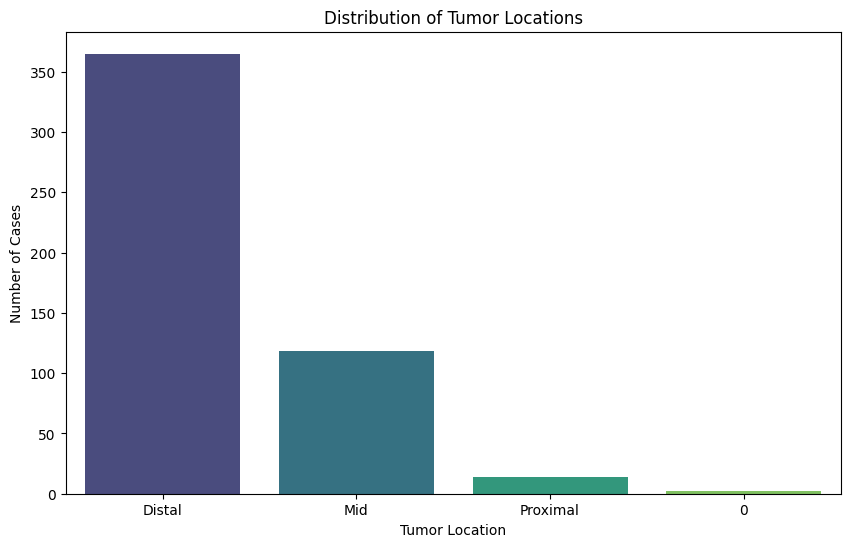

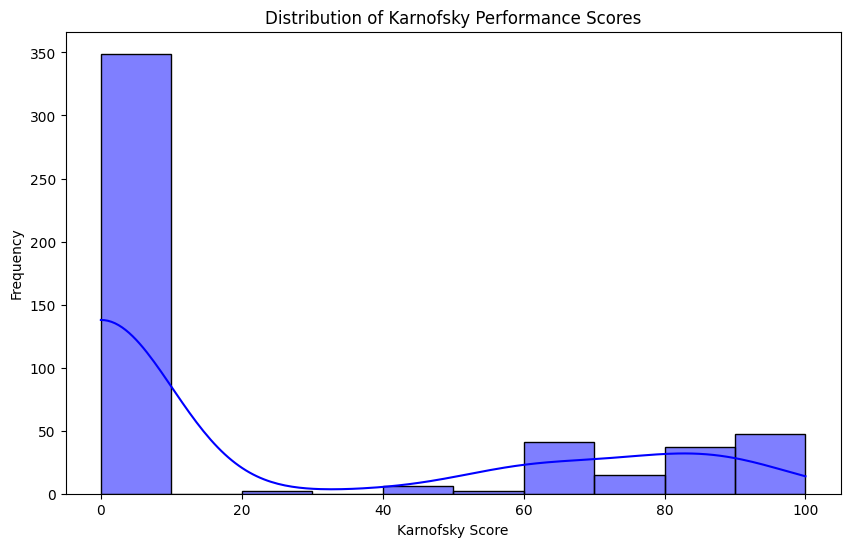

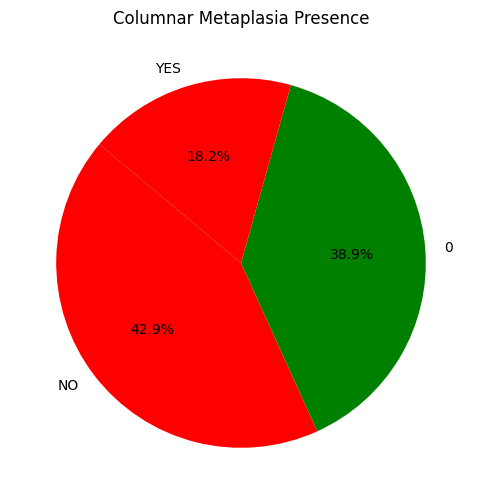

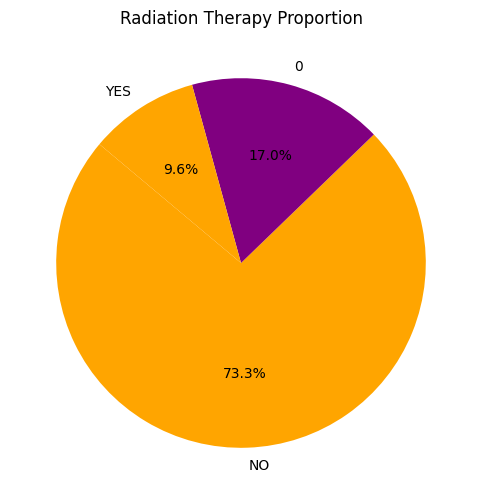

<ipython-input-16-0906adadfeef>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette="coolwarm")


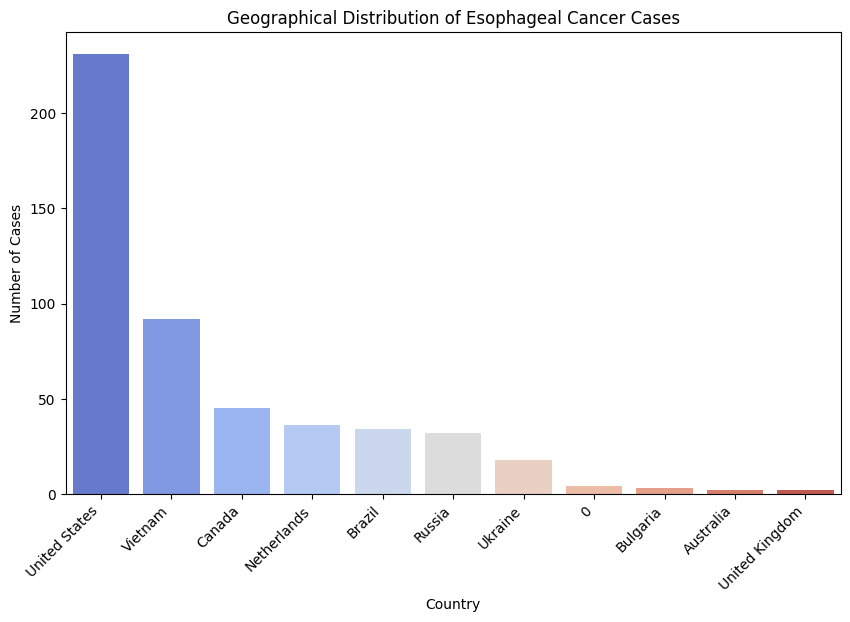

<ipython-input-16-0906adadfeef>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=outcome_table['vital_status'], y=outcome_table['days_to_death'].dropna(), palette="magma")


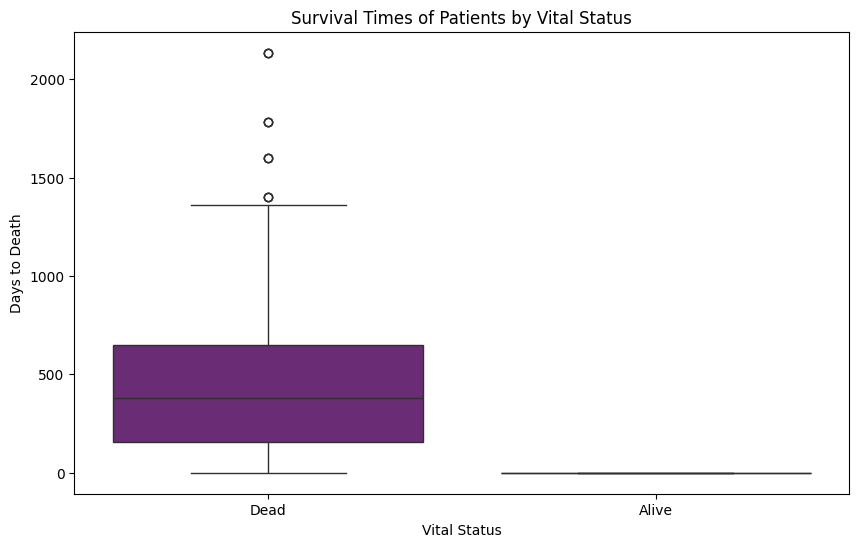

<ipython-input-16-0906adadfeef>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=treatment_counts.index, y=treatment_counts.values, palette="Blues")


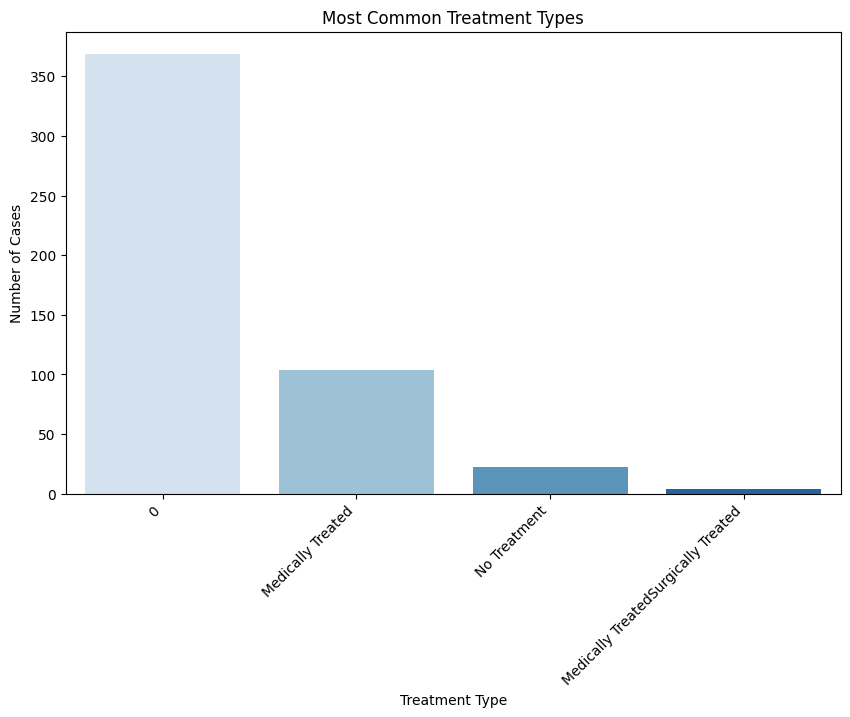

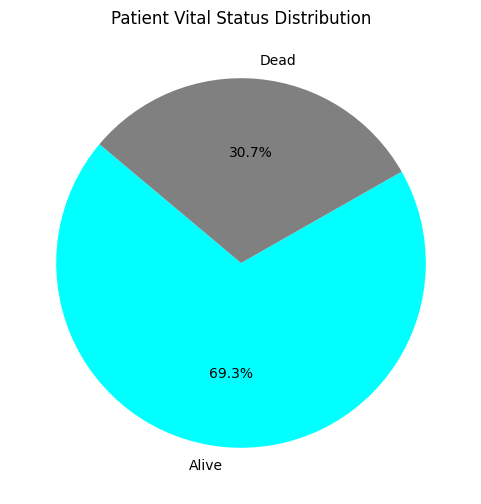

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
patient_table = pd.read_csv("Patient_table.csv")
diagnosis_table = pd.read_csv("diagnosis_table.csv")
treatment_table = pd.read_csv("treatment_table.csv")
outcome_table = pd.read_csv("outcome_table.csv")
country_table = pd.read_csv("country_table.csv")

# 1. Tumor Location Distribution
plt.figure(figsize=(10, 6))
tumor_location_counts = diagnosis_table['primary_pathology_esophageal_tumor_cental_location'].value_counts()
sns.barplot(x=tumor_location_counts.index, y=tumor_location_counts.values, palette="viridis")
plt.title("Distribution of Tumor Locations")
plt.xlabel("Tumor Location")
plt.ylabel("Number of Cases")
plt.show()

# 2. Karnofsky Performance Scores Distribution
plt.figure(figsize=(10, 6))
sns.histplot(outcome_table['primary_pathology_karnofsky_performance_score'].dropna(), bins=10, kde=True, color="blue")
plt.title("Distribution of Karnofsky Performance Scores")
plt.xlabel("Karnofsky Score")
plt.ylabel("Frequency")
plt.show()

# 3. Columnar Metaplasia Presence
plt.figure(figsize=(6, 6))
metaplasia_counts = diagnosis_table['primary_pathology_columnar_metaplasia_present'].value_counts()
metaplasia_labels = metaplasia_counts.index.astype(str)  # Ensure labels match data dynamically
plt.pie(metaplasia_counts, labels=metaplasia_labels, autopct='%1.1f%%', startangle=140, colors=["red", "green"])
plt.title("Columnar Metaplasia Presence")
plt.show()

# 4. Radiation Therapy Proportion
plt.figure(figsize=(6, 6))
radiation_counts = treatment_table['primary_pathology_radiation_therapy'].value_counts()
radiation_labels = radiation_counts.index.astype(str)  # Ensure dynamic labels
plt.pie(radiation_counts, labels=radiation_labels, autopct='%1.1f%%', startangle=140, colors=["orange", "purple"])
plt.title("Radiation Therapy Proportion")
plt.show()

# 5. Geographical Distribution of Cases
plt.figure(figsize=(10, 6))
country_counts = country_table['country'].value_counts()
sns.barplot(x=country_counts.index, y=country_counts.values, palette="coolwarm")
plt.title("Geographical Distribution of Esophageal Cancer Cases")
plt.xlabel("Country")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45, ha="right")
plt.show()

# 6. Survival Times of Patients
plt.figure(figsize=(10, 6))
sns.boxplot(x=outcome_table['vital_status'], y=outcome_table['days_to_death'].dropna(), palette="magma")
plt.title("Survival Times of Patients by Vital Status")
plt.xlabel("Vital Status")
plt.ylabel("Days to Death")
plt.show()

# 7. Most Common Treatment Types
plt.figure(figsize=(10, 6))
treatment_counts = treatment_table['antireflux_treatment_types'].value_counts()
sns.barplot(x=treatment_counts.index, y=treatment_counts.values, palette="Blues")
plt.title("Most Common Treatment Types")
plt.xlabel("Treatment Type")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45, ha="right")
plt.show()

# 8. Number of Patients Still Alive
plt.figure(figsize=(6, 6))
vital_counts = outcome_table['vital_status'].value_counts()
vital_labels = vital_counts.index
plt.pie(vital_counts, labels=vital_labels, autopct='%1.1f%%', startangle=140, colors=["cyan", "grey"])
plt.title("Patient Vital Status Distribution")
plt.show()


<ipython-input-17-1a0a8cf169e6>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tumor_location_counts.index, y=tumor_location_counts.values, palette="Set2")


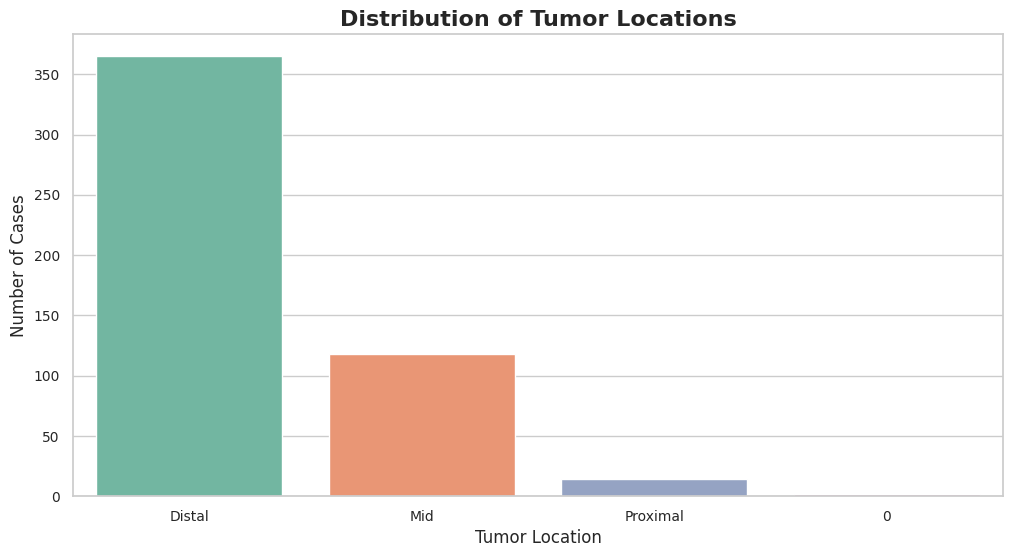

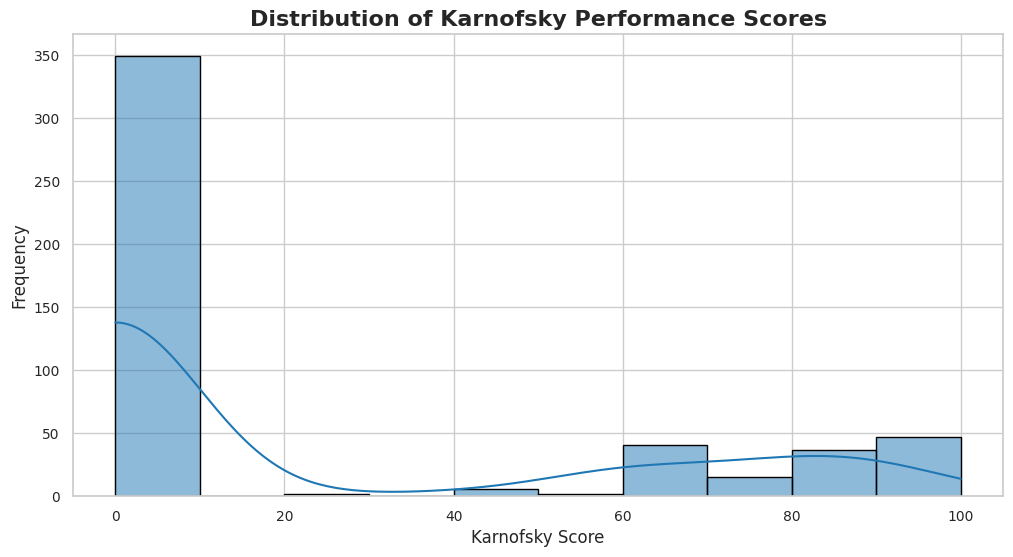

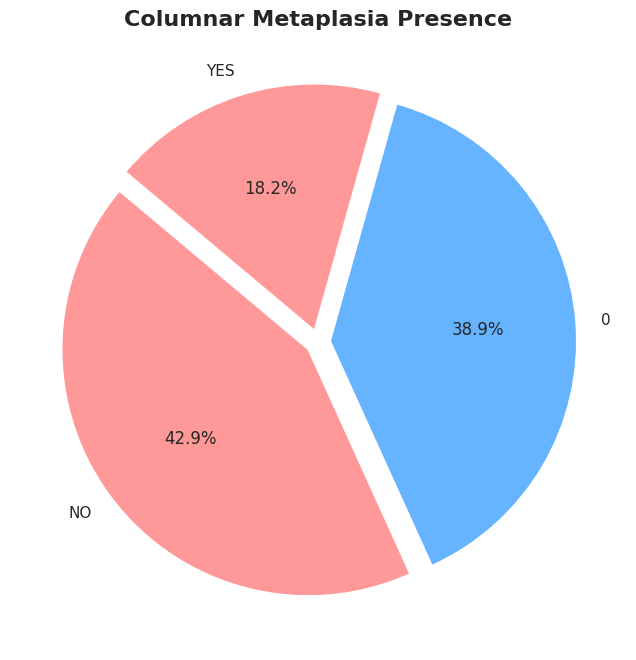

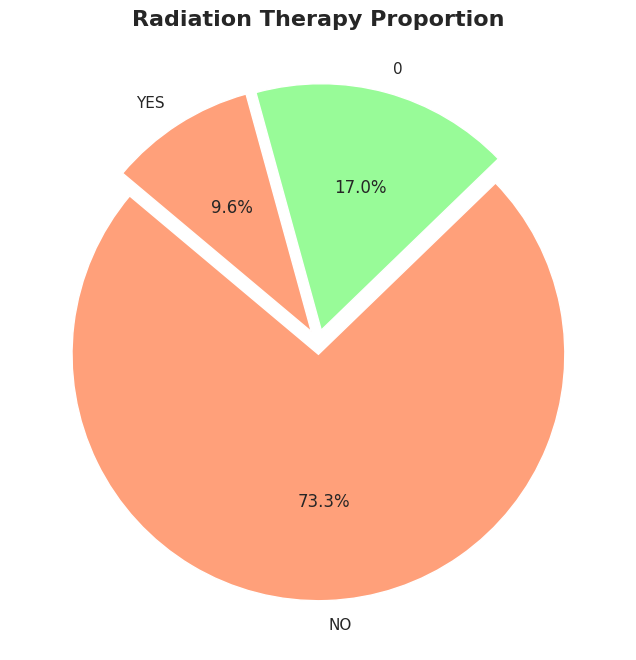

<ipython-input-17-1a0a8cf169e6>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette="Spectral")


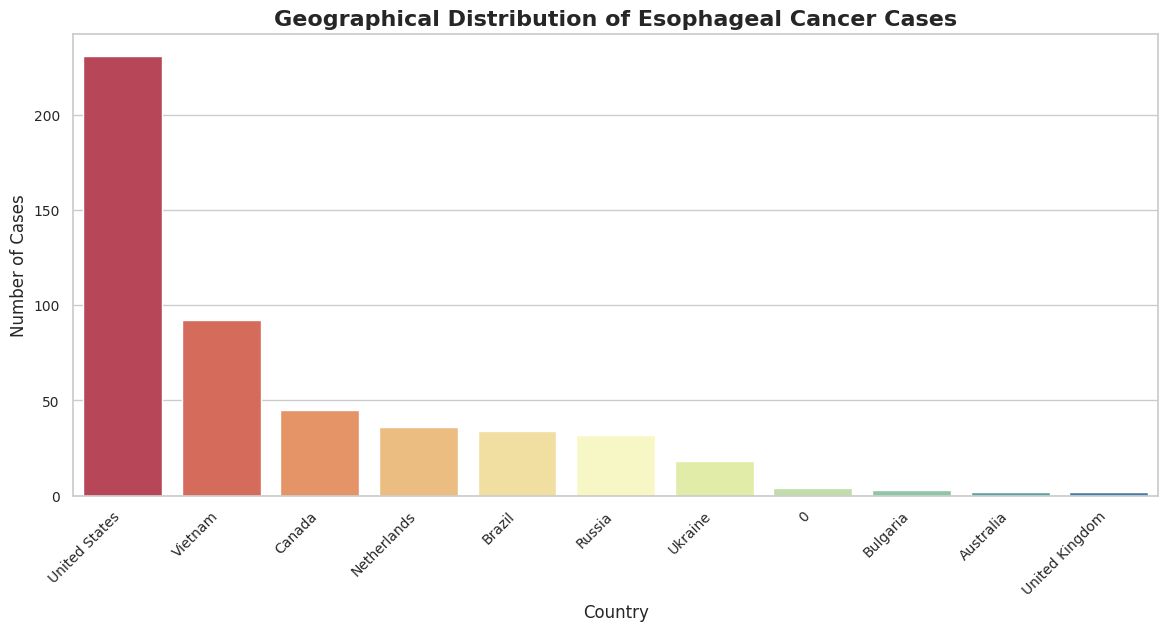

<ipython-input-17-1a0a8cf169e6>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=outcome_table['vital_status'], y=outcome_table['days_to_death'].dropna(), palette="coolwarm")


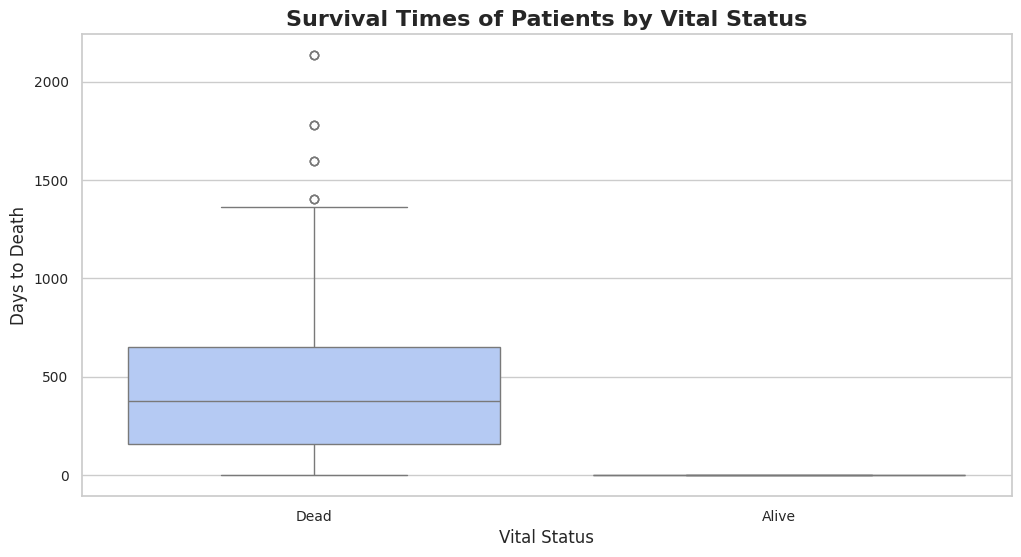

<ipython-input-17-1a0a8cf169e6>:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=treatment_counts.index, y=treatment_counts.values, palette="RdYlGn")


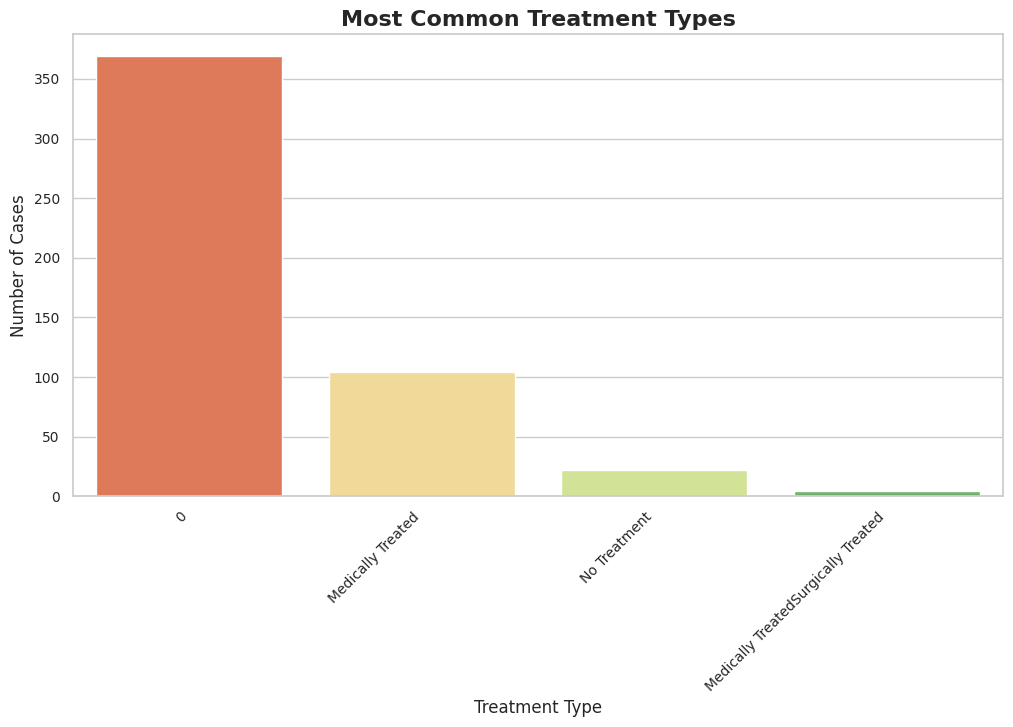

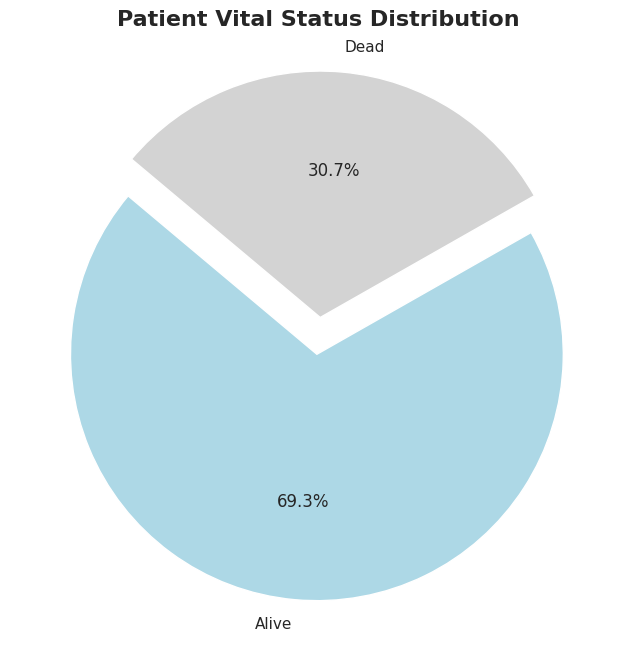

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
patient_table = pd.read_csv("Patient_table.csv")
diagnosis_table = pd.read_csv("diagnosis_table.csv")
treatment_table = pd.read_csv("treatment_table.csv")
outcome_table = pd.read_csv("outcome_table.csv")
country_table = pd.read_csv("country_table.csv")

# Set a stylish theme for visualizations
sns.set_theme(style="whitegrid", palette="pastel")

# 1. Tumor Location Distribution
plt.figure(figsize=(12, 6))
tumor_location_counts = diagnosis_table['primary_pathology_esophageal_tumor_cental_location'].value_counts()
sns.barplot(x=tumor_location_counts.index, y=tumor_location_counts.values, palette="Set2")
plt.title("Distribution of Tumor Locations", fontsize=16, fontweight='bold')
plt.xlabel("Tumor Location", fontsize=12)
plt.ylabel("Number of Cases", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 2. Karnofsky Performance Scores Distribution
plt.figure(figsize=(12, 6))
sns.histplot(outcome_table['primary_pathology_karnofsky_performance_score'].dropna(), bins=10, kde=True, color="#1f77b4", edgecolor="black")
plt.title("Distribution of Karnofsky Performance Scores", fontsize=16, fontweight='bold')
plt.xlabel("Karnofsky Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 3. Columnar Metaplasia Presence
plt.figure(figsize=(8, 8))
metaplasia_counts = diagnosis_table['primary_pathology_columnar_metaplasia_present'].value_counts()
metaplasia_labels = metaplasia_counts.index.tolist()  # Dynamically set labels based on data
plt.pie(
    metaplasia_counts,
    labels=metaplasia_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=["#ff9999", "#66b3ff"],
    explode=[0.05] * len(metaplasia_labels),  # Slightly explode all slices for effect
)
plt.title("Columnar Metaplasia Presence", fontsize=16, fontweight='bold')
plt.show()

# 4. Radiation Therapy Proportion
plt.figure(figsize=(8, 8))
radiation_counts = treatment_table['primary_pathology_radiation_therapy'].value_counts()
radiation_labels = radiation_counts.index.tolist()  # Dynamically generate labels
plt.pie(
    radiation_counts,
    labels=radiation_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=["#ffa07a", "#98fb98"],
    explode=[0.05] * len(radiation_labels),  # Slightly explode all slices for effect
)
plt.title("Radiation Therapy Proportion", fontsize=16, fontweight='bold')
plt.show()
# 5. Geographical Distribution of Cases
plt.figure(figsize=(14, 6))
country_counts = country_table['country'].value_counts()
sns.barplot(x=country_counts.index, y=country_counts.values, palette="Spectral")
plt.title("Geographical Distribution of Esophageal Cancer Cases", fontsize=16, fontweight='bold')
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Cases", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 6. Survival Times of Patients
plt.figure(figsize=(12, 6))
sns.boxplot(x=outcome_table['vital_status'], y=outcome_table['days_to_death'].dropna(), palette="coolwarm")
plt.title("Survival Times of Patients by Vital Status", fontsize=16, fontweight='bold')
plt.xlabel("Vital Status", fontsize=12)
plt.ylabel("Days to Death", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 7. Most Common Treatment Types
plt.figure(figsize=(12, 6))
treatment_counts = treatment_table['antireflux_treatment_types'].value_counts()
sns.barplot(x=treatment_counts.index, y=treatment_counts.values, palette="RdYlGn")
plt.title("Most Common Treatment Types", fontsize=16, fontweight='bold')
plt.xlabel("Treatment Type", fontsize=12)
plt.ylabel("Number of Cases", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 8. Number of Patients Still Alive
plt.figure(figsize=(8, 8))
vital_counts = outcome_table['vital_status'].value_counts()
vital_labels = vital_counts.index
plt.pie(vital_counts, labels=vital_labels, autopct='%1.1f%%', startangle=140, colors=["#add8e6", "#d3d3d3"], explode=(0.05, 0.1))
plt.title("Patient Vital Status Distribution", fontsize=16, fontweight='bold')
plt.show()


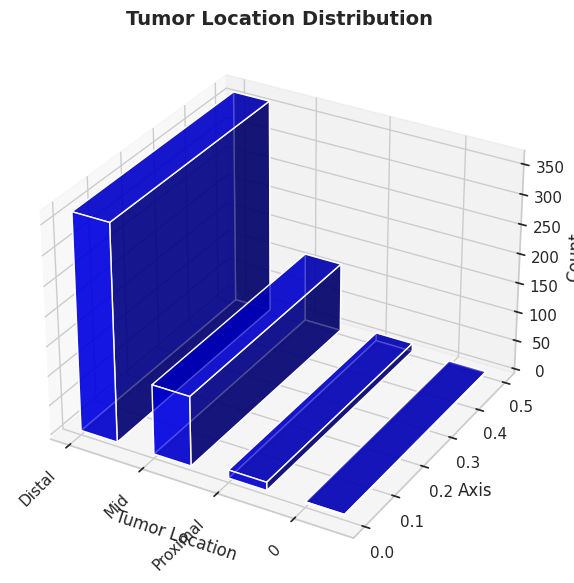

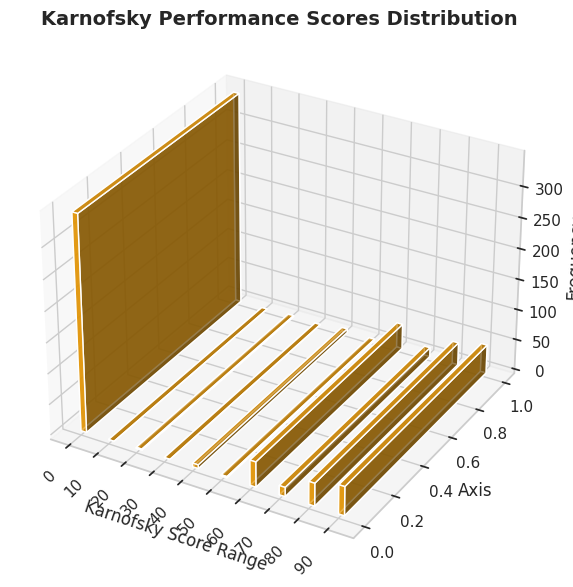

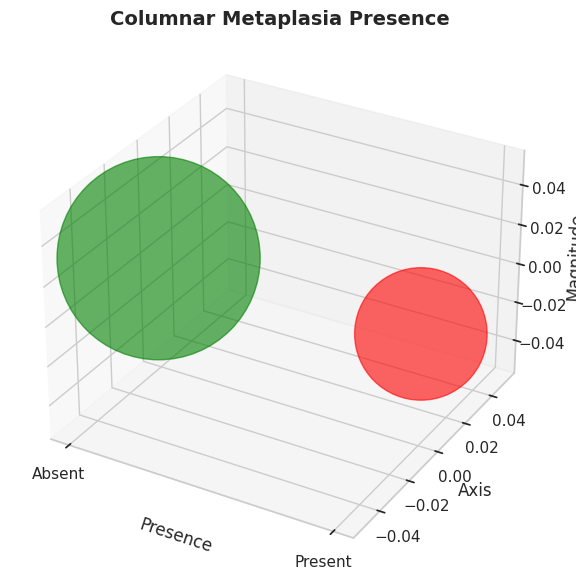

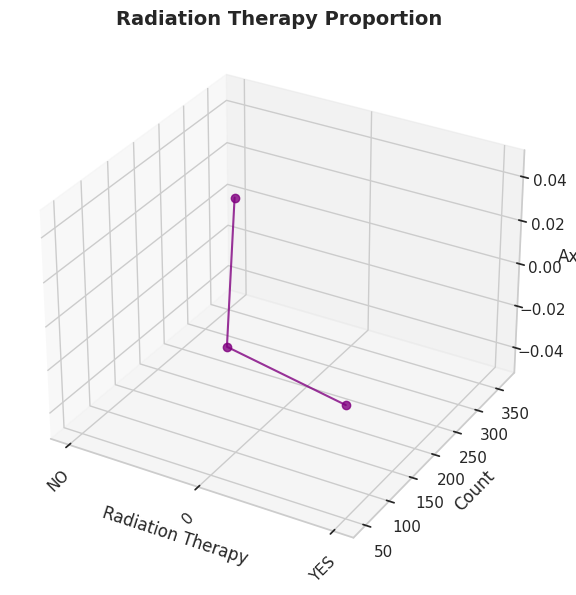

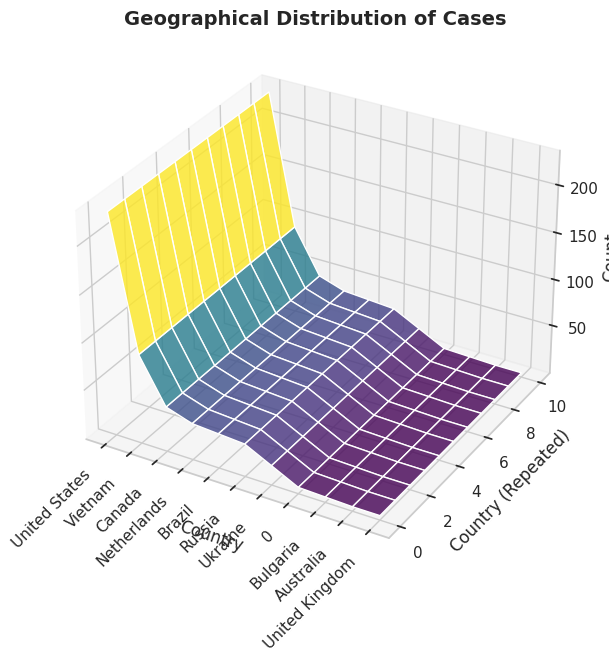

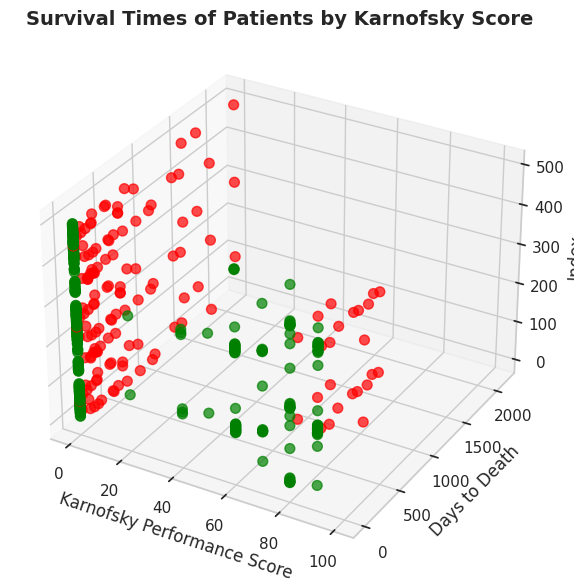

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the data
patient_table = pd.read_csv("Patient_table.csv")
diagnosis_table = pd.read_csv("diagnosis_table.csv")
treatment_table = pd.read_csv("treatment_table.csv")
outcome_table = pd.read_csv("outcome_table.csv")
country_table = pd.read_csv("country_table.csv")

# Ensure proper formatting of key columns
diagnosis_table['primary_pathology_columnar_metaplasia_present'] = diagnosis_table['primary_pathology_columnar_metaplasia_present'].map({'YES': 1, 'NO': 0})

# 1. Tumor Location Distribution - 3D Bar Chart
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
tumor_location_counts = diagnosis_table['primary_pathology_esophageal_tumor_cental_location'].value_counts()
x = np.arange(len(tumor_location_counts))
y = [0] * len(tumor_location_counts)
z = [0] * len(tumor_location_counts)
dx = [0.5] * len(tumor_location_counts)
dy = [0.5] * len(tumor_location_counts)
dz = tumor_location_counts.values
ax.bar3d(x, y, z, dx, dy, dz, color="blue", alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(tumor_location_counts.index, rotation=45, ha='right')
ax.set_title("Tumor Location Distribution", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Location")
ax.set_ylabel("Axis")
ax.set_zlabel("Count")
plt.show()

# 2. Karnofsky Performance Scores Distribution - 3D Histogram
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
karnofsky_scores = outcome_table['primary_pathology_karnofsky_performance_score'].dropna()
hist, edges = np.histogram(karnofsky_scores, bins=10)
x = edges[:-1]
y = [0] * len(x)
z = [0] * len(x)
dx = [2] * len(x)
dy = [1] * len(x)
dz = hist
ax.bar3d(x, y, z, dx, dy, dz, color="orange", alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels([str(int(val)) for val in edges[:-1]], rotation=45, ha='right')
ax.set_title("Karnofsky Performance Scores Distribution", fontsize=14, fontweight='bold')
ax.set_xlabel("Karnofsky Score Range")
ax.set_ylabel("Axis")
ax.set_zlabel("Frequency")
plt.show()

# 3. Columnar Metaplasia Presence - 3D Pie Chart Alternative (Scatter Representation)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
metaplasia_counts = diagnosis_table['primary_pathology_columnar_metaplasia_present'].value_counts()
x = np.array([1, 2])
y = np.zeros(len(metaplasia_counts))
z = [0] * len(metaplasia_counts)
sizes = metaplasia_counts.values * 100
colors = ["green", "red"]
ax.scatter(x, y, z, s=sizes, c=colors, alpha=0.6)
ax.set_xticks(x)
ax.set_xticklabels(["Absent", "Present"])
ax.set_title("Columnar Metaplasia Presence", fontsize=14, fontweight='bold')
ax.set_xlabel("Presence")
ax.set_ylabel("Axis")
ax.set_zlabel("Magnitude")
plt.show()

# 4. Radiation Therapy Proportion - 3D Line Chart
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
radiation_counts = treatment_table['primary_pathology_radiation_therapy'].value_counts()
x = np.arange(len(radiation_counts))
y = radiation_counts.values
z = [0] * len(radiation_counts)
ax.plot(x, y, z, color="purple", marker="o", alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(radiation_counts.index, rotation=45)
ax.set_title("Radiation Therapy Proportion", fontsize=14, fontweight='bold')
ax.set_xlabel("Radiation Therapy")
ax.set_ylabel("Count")
ax.set_zlabel("Axis")
plt.show()

# 5. Geographical Distribution of Cases - 3D Surface Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
country_counts = country_table['country'].value_counts()
x = np.arange(len(country_counts))
y = np.arange(len(country_counts))
x, y = np.meshgrid(x, y)
z = np.array([country_counts.values] * len(country_counts))
ax.plot_surface(x, y, z, cmap="viridis", alpha=0.8)
ax.set_xticks(range(len(country_counts)))
ax.set_xticklabels(country_counts.index, rotation=45, ha='right')
ax.set_title("Geographical Distribution of Cases", fontsize=14, fontweight='bold')
ax.set_xlabel("Country")
ax.set_ylabel("Country (Repeated)")
ax.set_zlabel("Count")
plt.show()

# 6. Survival Times of Patients - 3D Scatter Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
outcome_cleaned = outcome_table.dropna(subset=['primary_pathology_karnofsky_performance_score', 'days_to_death', 'vital_status'])
karnofsky_scores = outcome_cleaned['primary_pathology_karnofsky_performance_score']
days_to_death = outcome_cleaned['days_to_death']
vital_status = outcome_cleaned['vital_status']
colors = {'Alive': 'green', 'Dead': 'red'}
color_map = [colors.get(status, 'gray') for status in vital_status]
ax.scatter(karnofsky_scores, days_to_death, np.arange(len(karnofsky_scores)), c=color_map, alpha=0.7, s=50)
ax.set_xlabel("Karnofsky Performance Score", fontsize=12)
ax.set_ylabel("Days to Death", fontsize=12)
ax.set_zlabel("Index", fontsize=12)
ax.set_title("Survival Times of Patients by Karnofsky Score", fontsize=14, fontweight='bold')
plt.show()


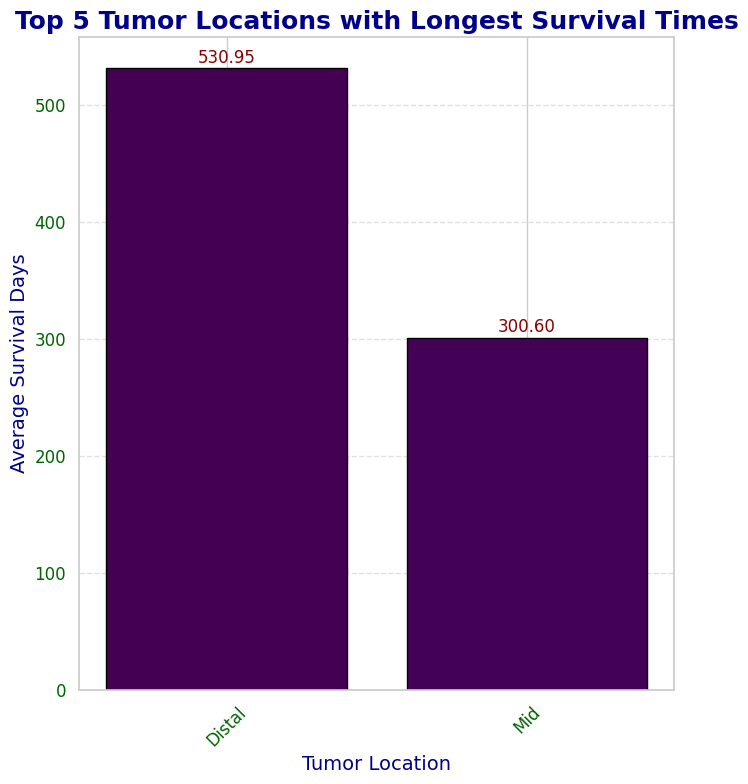

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# Load the CSV files into Pandas DataFrames
diagnosis_table = pd.read_csv('diagnosis_table.csv')
visit_table = pd.read_csv('Visit_table.csv')
outcome_table = pd.read_csv('outcome_table.csv')

# Ensure necessary columns are present and valid
outcome_table['days_to_death'] = pd.to_numeric(outcome_table['days_to_death'], errors='coerce')
outcome_table['vital_status'] = outcome_table['vital_status'].str.strip()

# Merge the dataframes
merged_df = pd.merge(diagnosis_table, visit_table, on='visit_id')
merged_df = pd.merge(merged_df, outcome_table, on='visit_id')

# Filter for patients with 'Dead' vital status
filtered_df = merged_df[merged_df['vital_status'] == 'Dead']

# Calculate average survival days and patient count for each tumor location
result_df = (
    filtered_df.groupby('primary_pathology_esophageal_tumor_cental_location')
    .agg(AvgSurvivalDays=('days_to_death', 'mean'), PatientCount=('days_to_death', 'count'))
    .reset_index()
)

# Sort by average survival days in descending order and take the top 5
result_df = result_df.sort_values(by='AvgSurvivalDays', ascending=False).head(5)

# Visualization
colors = cm.viridis(range(len(result_df)))  # Use a colormap for dynamic and visually appealing colors

plt.figure(figsize=(7, 8))
bars = plt.bar(
    result_df['primary_pathology_esophageal_tumor_cental_location'],
    result_df['AvgSurvivalDays'],
    color=colors,
    edgecolor='black'
)

plt.title('Top 5 Tumor Locations with Longest Survival Times', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Tumor Location', fontsize=14, color='darkblue')
plt.ylabel('Average Survival Days', fontsize=14, color='darkblue')
plt.xticks(rotation=45, fontsize=12, color='darkgreen')
plt.yticks(fontsize=12, color='darkgreen')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars with survival days
for bar, val in zip(bars, result_df['AvgSurvivalDays']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{val:.2f}', ha='center', fontsize=12, color='darkred')

plt.tight_layout()
plt.show()


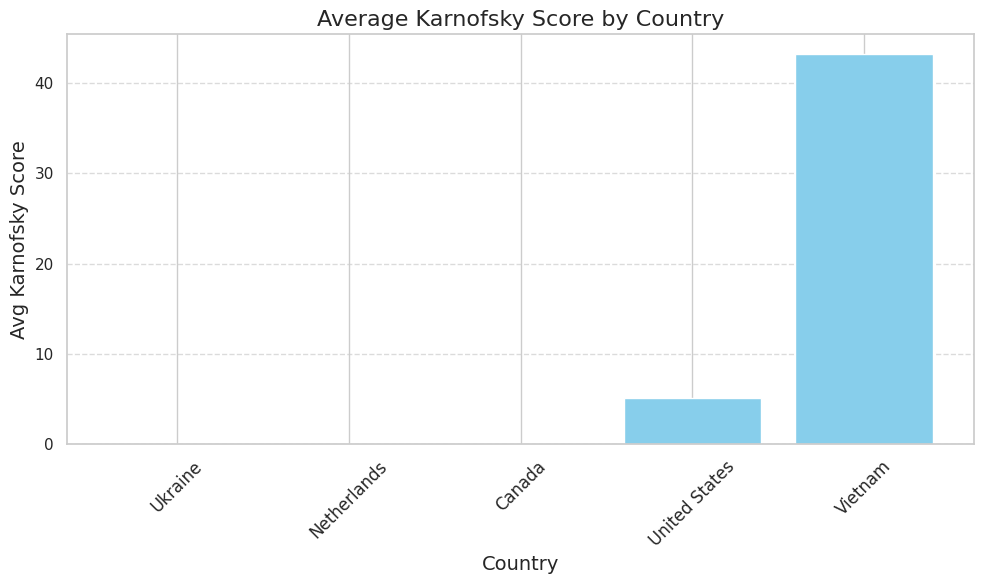

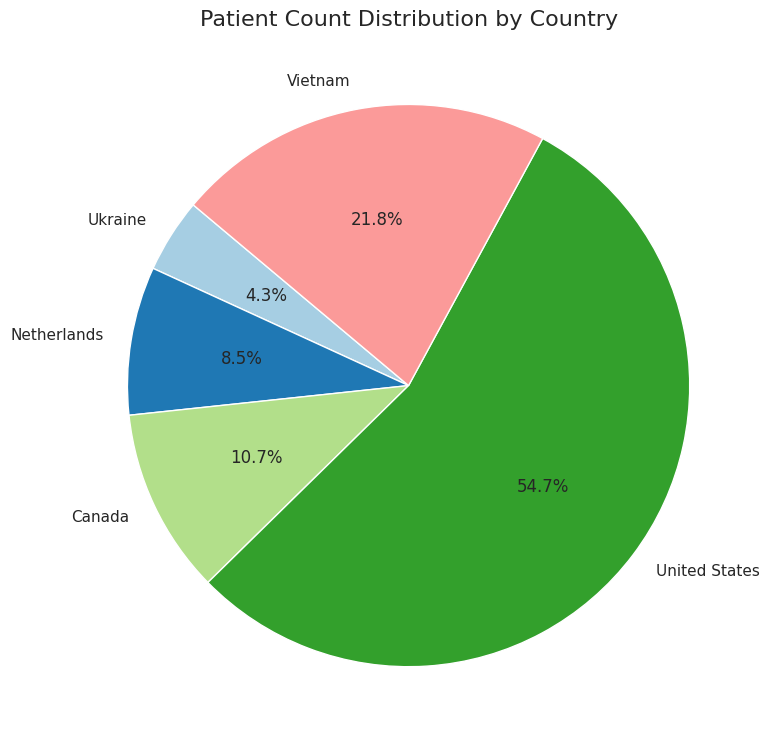

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example Data (Replace with your actual data)
data = {
    'Country': ['Ukraine', 'Netherlands', 'Canada', 'United States', 'Vietnam'],
    'AvgKarnofskyScore': [0.00, 0.00, 0.00, 5.15, 43.26],
    'PatientCount': [18, 36, 45, 231, 92]
}

df = pd.DataFrame(data)

# Bar Chart: Average Karnofsky Score by Country
plt.figure(figsize=(10, 6))
plt.bar(df['Country'], df['AvgKarnofskyScore'], color='skyblue')
plt.title('Average Karnofsky Score by Country', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Avg Karnofsky Score', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Pie Chart: Patient Count Distribution by Country
plt.figure(figsize=(8, 8))
plt.pie(
    df['PatientCount'],
    labels=df['Country'],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title('Patient Count Distribution by Country', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import plotly.express as px

# Simulated Dataset (Replace this with actual esophageal cancer dataset)
np.random.seed(42)
data = {
    'Age': np.random.randint(30, 80, 500),
    'Gender': np.random.choice(['Male', 'Female'], 500),
    'TumorStage': np.random.choice(['Stage I', 'Stage II', 'Stage III', 'Stage IV'], 500),
    'TreatmentType': np.random.choice(['Radiation', 'Chemotherapy', 'Surgery'], 500),
    'Demographics': np.random.choice(['Urban', 'Rural'], 500),
    'Outcome': np.random.choice(['Success', 'Failure'], 500)
}

df = pd.DataFrame(data)

# Preprocessing
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['TumorStage'] = df['TumorStage'].map({'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4})
df['TreatmentType'] = df['TreatmentType'].map({'Radiation': 1, 'Chemotherapy': 2, 'Surgery': 3})
df['Demographics'] = df['Demographics'].map({'Urban': 1, 'Rural': 0})
df['Outcome'] = df['Outcome'].map({'Success': 1, 'Failure': 0})

# Features and Target
X = df[['Age', 'Gender', 'TumorStage', 'TreatmentType', 'Demographics']]
y = df['Outcome']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Decision Tree
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# Random Forest
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

# Evaluation Metrics
def evaluate_model(model_name, y_test, y_pred):
    print(f"Model: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-Score:", f1_score(y_test, y_pred))
    print("\n")

evaluate_model("Logistic Regression", y_test, y_pred_log)
evaluate_model("Decision Tree", y_test, y_pred_tree)
evaluate_model("Random Forest", y_test, y_pred_forest)

# 3D Visualization: Tumor Stage, Treatment Type, and Age
fig = px.scatter_3d(
    df,
    x='TumorStage',
    y='TreatmentType',
    z='Age',
    color='Outcome',
    title='3D Visualization of Tumor Stage, Treatment, and Age'
)
fig.show()

# Geographical Mapping (Simulated Data)
geo_data = {
    'Country': ['USA', 'India', 'China', 'Brazil', 'Germany'],
    'Cases': [500, 700, 800, 400, 300],
    'Effectiveness': [70, 60, 75, 65, 80]
}
geo_df = pd.DataFrame(geo_data)

fig = px.choropleth(
    geo_df,
    locations="Country",
    locationmode="country names",
    color="Effectiveness",
    hover_name="Country",
    title="Global Treatment Effectiveness for Esophageal Cancer"
)
fig.show()


Model: Logistic Regression
Accuracy: 0.53
Precision: 0.5106382978723404
Recall: 0.5
F1-Score: 0.5052631578947369


Model: Decision Tree
Accuracy: 0.56
Precision: 0.5344827586206896
Recall: 0.6458333333333334
F1-Score: 0.5849056603773585


Model: Random Forest
Accuracy: 0.49
Precision: 0.46511627906976744
Recall: 0.4166666666666667
F1-Score: 0.43956043956043955




Logistic Regression Metrics:
Accuracy: 0.53
Precision: 0.51
Recall: 0.50
F1-Score: 0.51


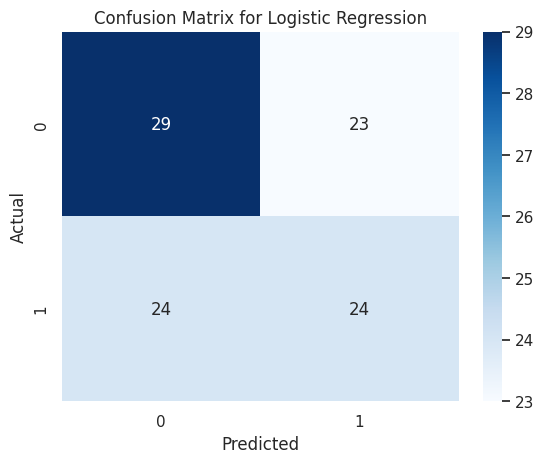

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)

# Evaluate
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Random Forest Metrics:
Accuracy: 0.49
Precision: 0.47
Recall: 0.42
F1-Score: 0.44


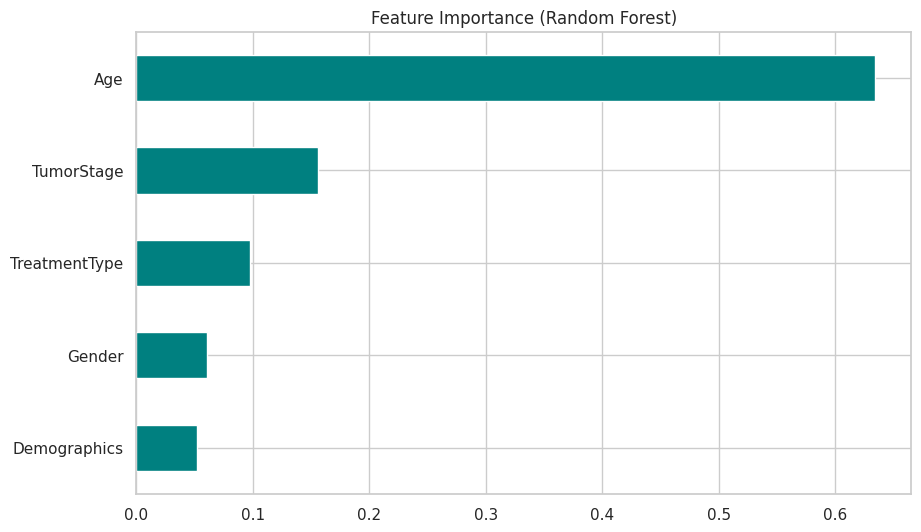

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Train Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate for Random Forest
y_pred_rf = rf.predict(X_test)
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.2f}")

# Feature importance visualization
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.sort_values().plot(kind='barh', figsize=(10, 6), color='teal')
plt.title("Feature Importance (Random Forest)")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build Neural Network
model = Sequential([
    Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Neural Network Accuracy: {accuracy:.2f}")

# Predict
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype("int32")

print("Neural Network Metrics:")
print(f"Precision: {precision_score(y_test, y_pred_nn):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_nn):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_nn):.2f}")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5450 - loss: 0.6954 - val_accuracy: 0.5500 - val_loss: 0.6880
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4950 - loss: 0.6953 - val_accuracy: 0.5125 - val_loss: 0.6873
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5405 - loss: 0.6849 - val_accuracy: 0.5500 - val_loss: 0.6853
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4936 - loss: 0.6924 - val_accuracy: 0.5125 - val_loss: 0.6855
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5308 - loss: 0.6870 - val_accuracy: 0.5500 - val_loss: 0.6840
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5335 - loss: 0.6830 - val_accuracy: 0.5500 - val_loss: 0.6841
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5282 - loss: 0.6835 - val_accuracy: 0.5250 - val_loss: 0.6844
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6094 - loss: 0.6706 - val_accuracy: 0.5250 - val_loss: 0.6853
Ep

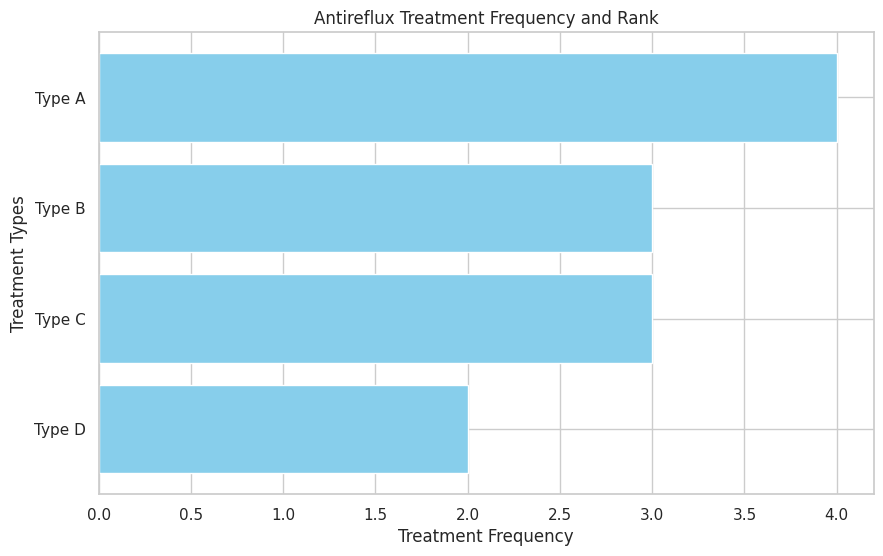

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data - replace this with your actual data
data = {
    'antireflux_treatment_types': ['Type A', 'Type B', 'Type C', 'Type D', 'Type A', 'Type B', 'Type C', 'Type A', 'Type D', 'Type B', 'Type C', 'Type A'],
    'treatment_id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
}

# Convert data to a pandas DataFrame
df = pd.DataFrame(data)

# Count the frequency of each treatment type
frequency_df = df['antireflux_treatment_types'].value_counts().reset_index()
frequency_df.columns = ['antireflux_treatment_types', 'treatment_frequency']

# Add rank based on frequency
frequency_df['treatment_rank'] = frequency_df['treatment_frequency'].rank(ascending=False, method='dense')

# Sort by rank
frequency_df = frequency_df.sort_values('treatment_rank')

# Plot the data
plt.figure(figsize=(10, 6))
plt.barh(frequency_df['antireflux_treatment_types'], frequency_df['treatment_frequency'], color='skyblue')
plt.xlabel('Treatment Frequency')
plt.ylabel('Treatment Types')
plt.title('Antireflux Treatment Frequency and Rank')
plt.gca().invert_yaxis()  # Invert y-axis to match ascending rank
plt.show()


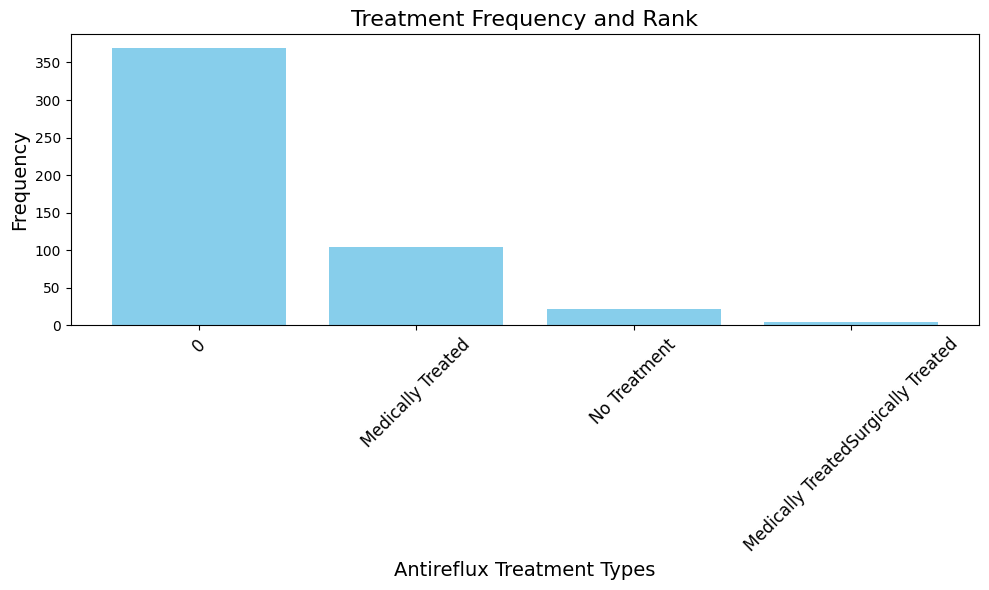

            antireflux_treatment_types  treatment_frequency  treatment_rank
0                                    0                  369             1.0
1                    Medically Treated                  104             2.0
3                         No Treatment                   22             3.0
2  Medically TreatedSurgically Treated                    4             4.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file (replace 'treatment_table.csv' with the actual file path)
df = pd.read_csv('treatment_table.csv')

# Group by `antireflux_treatment_types` and count the `treatment_id`
# This replicates the SQL query logic
treatment_summary = (
    df.groupby('antireflux_treatment_types')['treatment_id']
    .count()
    .reset_index(name='treatment_frequency')
)

# Add a rank column based on frequency in descending order
treatment_summary['treatment_rank'] = treatment_summary['treatment_frequency'].rank(ascending=False, method='min')

# Sort by rank to match the order in SQL query
treatment_summary = treatment_summary.sort_values('treatment_rank')

# Visualization: Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(treatment_summary['antireflux_treatment_types'], treatment_summary['treatment_frequency'], color='skyblue')
plt.title('Treatment Frequency and Rank', fontsize=16)
plt.xlabel('Antireflux Treatment Types', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

# Display the summary to verify output matches SQL results
print(treatment_summary)


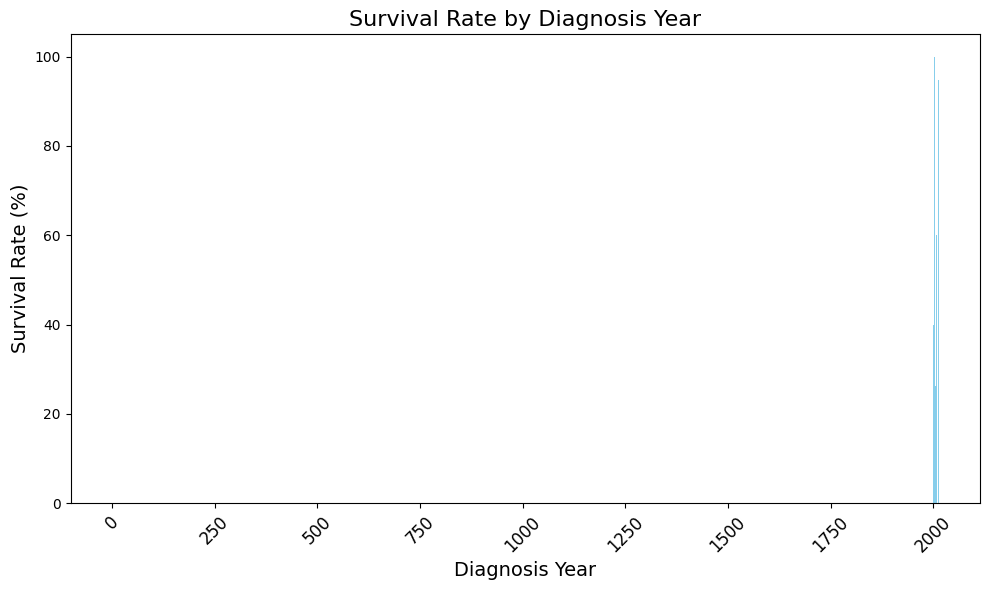

    primary_pathology_year_of_initial_pathologic_diagnosis  total_patients  \
0                                                 0.0                   14   
1                                              1998.0                    3   
2                                              1999.0                    9   
3                                              2000.0                   24   
4                                              2001.0                   40   
5                                              2003.0                    3   
6                                              2004.0                   17   
7                                              2005.0                   13   
8                                              2006.0                   19   
9                                              2007.0                   11   
10                                             2008.0                    5   
11                                             2009.0           

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV files (replace with actual file paths)
diagnosis_table = pd.read_csv('diagnosis_table.csv')
visit_table = pd.read_csv('Visit_table.csv')
outcome_table = pd.read_csv('outcome_table.csv')
patient_table = pd.read_csv('Patient_table.csv')

# Step 1: Merge tables to replicate JOINs in SQL
merged_df = (
    diagnosis_table
    .merge(visit_table, on='visit_id', how='inner')
    .merge(outcome_table, on='visit_id', how='inner')
    .merge(patient_table, on='patient_id', how='inner')
)

# Step 2: Group by diagnosis year and calculate metrics
summary = (
    merged_df.groupby('primary_pathology_year_of_initial_pathologic_diagnosis')
    .agg(
        total_patients=('patient_id', 'nunique'),
        alive_patients=('vital_status', lambda x: (x == 'Alive').sum())
    )
    .reset_index()
)

# Step 3: Calculate survival rate
summary['survival_rate'] = round((summary['alive_patients'] / summary['total_patients']) * 100, 2)

# Step 4: Sort data by diagnosis year
summary = summary.sort_values('primary_pathology_year_of_initial_pathologic_diagnosis')

# Step 5: Visualization: Survival Rate by Diagnosis Year
plt.figure(figsize=(10, 6))
plt.bar(summary['primary_pathology_year_of_initial_pathologic_diagnosis'], summary['survival_rate'], color='skyblue')
plt.title('Survival Rate by Diagnosis Year', fontsize=16)
plt.xlabel('Diagnosis Year', fontsize=14)
plt.ylabel('Survival Rate (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

# Display the summary table to verify results match SQL query
print(summary)


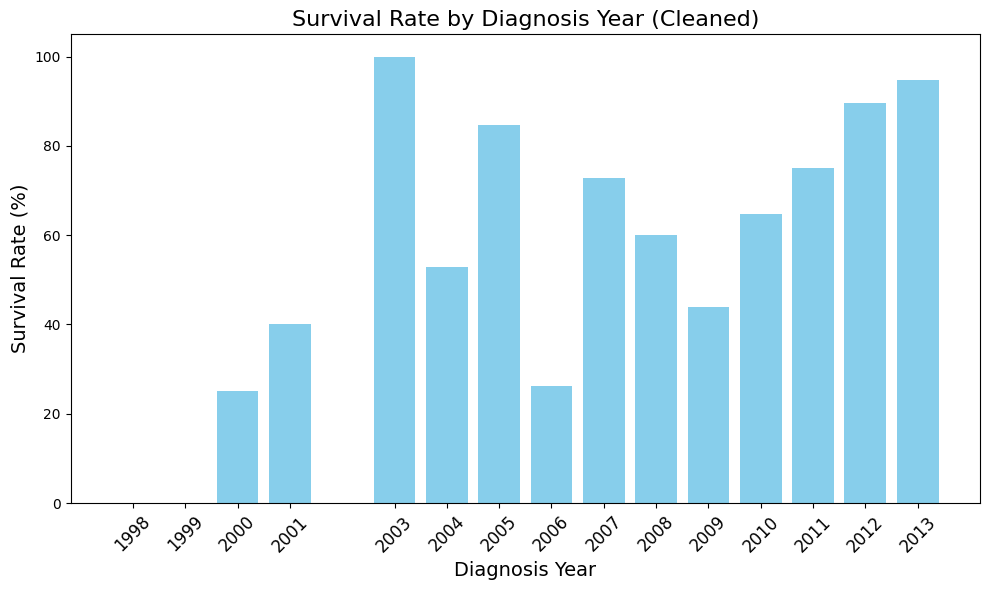

    primary_pathology_year_of_initial_pathologic_diagnosis  total_patients  \
1                                              1998.0                    3   
2                                              1999.0                    9   
3                                              2000.0                   24   
4                                              2001.0                   40   
5                                              2003.0                    3   
6                                              2004.0                   17   
7                                              2005.0                   13   
8                                              2006.0                   19   
9                                              2007.0                   11   
10                                             2008.0                    5   
11                                             2009.0                   25   
12                                             2010.0           

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter out invalid years (e.g., year 0.0)
summary_cleaned = summary[summary['primary_pathology_year_of_initial_pathologic_diagnosis'] > 0]

# Recreate the bar chart with cleaned data
plt.figure(figsize=(10, 6))
plt.bar(
    summary_cleaned['primary_pathology_year_of_initial_pathologic_diagnosis'],
    summary_cleaned['survival_rate'],
    color='skyblue'
)
plt.title('Survival Rate by Diagnosis Year (Cleaned)', fontsize=16)
plt.xlabel('Diagnosis Year', fontsize=14)
plt.ylabel('Survival Rate (%)', fontsize=14)
plt.xticks(
    summary_cleaned['primary_pathology_year_of_initial_pathologic_diagnosis'],
    rotation=45,
    fontsize=12
)
plt.tight_layout()
plt.show()

# Display the cleaned summary table for verification
print(summary_cleaned)


In [ ]:
print(country_table.columns)
print(patient_table.columns)
print(visit_table.columns)
print(outcome_table.columns)


Index(['patient_id', 'country', 'country_of_procurement',
       'state_province_of_procurement', 'city_of_procurement'],
      dtype='object')
Index(['s.no', 'patient_barcode', 'visit_id', 'tissue_source_site',
       'bcr_patient_uuid', 'patient_id', 'country_of_birth', 'gender',
       'height', 'weight', 'days_to_birth', 'race_list', 'ethnicity',
       'days_to_last_followup'],
      dtype='object')
Index(['visit_id', 'Visit_date', 'patient_id'], dtype='object')
Index(['visit_id', 'outcome_id',
       'primary_pathology_karnofsky_performance_score',
       'primary_pathology_eastern_cancer_oncology_group', 'vital_status',
       'days_to_death'],
      dtype='object')


In [ ]:
import pandas as pd

# Load data from CSV files
diagnosis_table = pd.read_csv('diagnosis_table.csv')
visit_table = pd.read_csv('Visit_table.csv')
outcome_table = pd.read_csv('outcome_table.csv')
patient_table = pd.read_csv('Patient_table.csv')

# Step 1: Merge tables based on relationships
merged_df = (
    diagnosis_table
    .merge(visit_table, on='visit_id', how='inner')    # Join Diagnosis and Visit tables
    .merge(outcome_table, on='visit_id', how='inner')  # Join Visit and Outcome tables
    .merge(patient_table, on='patient_id', how='inner')  # Join Patient table
)

# Step 2: Group by diagnosis year and vital status, then count unique patients
grouped_df = (
    merged_df.groupby(['primary_pathology_year_of_initial_pathologic_diagnosis', 'vital_status'])
    .agg(patient_count=('patient_id', 'nunique'))  # Count distinct patients
    .reset_index()
)

# Step 3: Sort by diagnosis year and patient count in descending order
sorted_df = grouped_df.sort_values(
    by=['primary_pathology_year_of_initial_pathologic_diagnosis', 'patient_count'],
    ascending=[True, False]
)

# Display the result
print(sorted_df)

# Optional: Save the result to a CSV file for further analysis
sorted_df.to_csv('diagnosis_year_patient_count.csv', index=False)


    primary_pathology_year_of_initial_pathologic_diagnosis vital_status  \
0                                                 0.0             Alive   
1                                                 0.0              Dead   
2                                              1998.0              Dead   
3                                              1999.0              Dead   
5                                              2000.0              Dead   
4                                              2000.0             Alive   
7                                              2001.0              Dead   
6                                              2001.0             Alive   
8                                              2003.0             Alive   
9                                              2004.0             Alive   
10                                             2004.0              Dead   
11                                             2005.0             Alive   
12                       

<Figure size 1200x600 with 0 Axes>

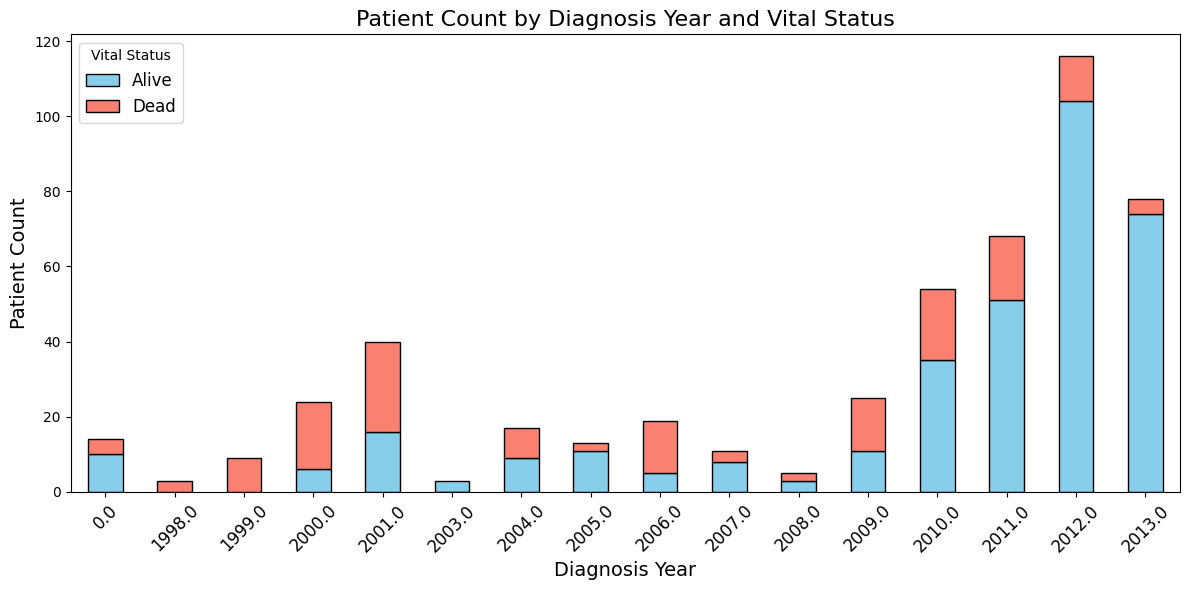

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the sorted results (replace with your actual DataFrame)
sorted_df = pd.read_csv('diagnosis_year_patient_count.csv')  # Or use the DataFrame directly

# Step 1: Pivot the data for visualization
pivot_df = sorted_df.pivot(
    index='primary_pathology_year_of_initial_pathologic_diagnosis',
    columns='vital_status',
    values='patient_count'
).fillna(0)

# Step 2: Plot the stacked bar chart
plt.figure(figsize=(12, 6))

# Create stacked bars for each vital_status
pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color={'Alive': 'skyblue', 'Dead': 'salmon'},
    edgecolor='black'
)

# Customize the chart
plt.title('Patient Count by Diagnosis Year and Vital Status', fontsize=16)
plt.xlabel('Diagnosis Year', fontsize=14)
plt.ylabel('Patient Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Vital Status', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()
